# Simulación de experimento


La mayor cantidad de experimentos los hemos hecho con 8 antenas en un arreglo circular de radio $r = 11.5$ cm. El medio de acoplamiento es agua destilada y sal, es la solución estudiada en este trabajo (https://doi.org/10.1118/1.4788640), en particular es la solución *salt 17.5* cuyas propiedades dieléctricas relativas son:

$ɛ^{*}_r≈ 76.95-26.97j$

Esto significa que la longitud de onda en el medio de acoplamiento será:

$λ≈ \frac{c}{f\sqrt{ɛ_r}}≈ \frac{3 × 10^{8}}{500 \times 10^{6}\sqrt{77}}≈ 7$ cm.

Los fantomas que usamos fueron:

- Cilindro de nylon de diámetro $3.5$ cm y propiedad dieléctrica: $ɛ^{*}_r≈ 3.1-0.0j$.

- Cilindro relleno con mezcla de Glycerol al 80% de diámetro $6.6$ cm, con propiedades dieléctricas: $ɛ^{*}_r≈ 40.0-20.0j$. Cuyas propiedades dieléctriccas las verificamos aquí: https://doi.org/10.1007/978-3-031-51723-5_3

- Cilindro relleno con Glycerol al 100% de diámetro $5.2$ cm, con propiedades dieléctricas: $ɛ^{*}_r≈ 10.0-7.75j$. El valor de la parte imaginaria lo obtuve utilizando la relación: $ɛ^{"} = \frac{\sigma}{\omega \epsilon_{0}}$, con $\sigma ≈ 0.25 $ S/m extraído de la Fig. 6 del trabajo: https://doi.org/10.1109/TMTT.2016.2638423

En todos los cilindros la permitividad relativa es menor, en el caso del nylon, es mucho menor. También hay que remarcar que en el caso del nylon no tiene pérdidas, es decir, la permitividad relativa tiene solo parte real.





## Para correr en Google Colab

Ejecutar este documento en forma dinámica:[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rirastorza/Intro2MI/blob/master/problema_directo/ejemplo_contrastes.ipynb)

In [1]:
%%capture
# install conda
!pip install -q condacolab
import condacolab
condacolab.install()
!which conda

# install meep (python)
!conda install -c conda-forge pymeep

## Parallel Meep (MPI version)
!conda create -n pmp -c conda-forge pymeep=*=mpi_mpich_*
!conda activate pmp

In [2]:
%%capture
!wget https://raw.githubusercontent.com/rirastorza/Intro2MI/refs/heads/main/problema_directo/forward.py


## Ejemplo de uso: simulación con FDTD

### 1. Cargo los parámetros de la simulación

Todos los parámetros a continuación conviene no cambiarlos. Aquí se setean los parámetros de la geometría del arreglo transmisor, el receptor, la frecuencia, etc.

In [3]:
from forward import *
import time as tm
import numpy as np
import matplotlib.pyplot as plt

start_time = tm.strftime('%H:%M:%S')
f = 580e6
sx = 0.3
sy = 0.3
box = [sx,sy]
a = 0.005
resolucion = 5
n = resolucion*sx/a


TRANSMISOR_parameters = TRANSMISOR_parameters()
TRANSMISOR_parameters.f = f
TRANSMISOR_parameters.amp = 7.5e4
TRANSMISOR_parameters.rhoS = 0.115
TRANSMISOR_parameters.S = 8.
RECEPTOR_parameters.f = f #frecuencia 1 GHz (por defecto)
RECEPTOR_parameters.amp = 7.5e4#3500 #Amplitud de la fuente
RECEPTOR_parameters.rhoS = 0.115 #radio de transmisores
RECEPTOR_parameters.S = 8. ##cantidad de transmisores (fuentes)
#Coordenadas antenas
angulo = np.linspace(0.0, 2.0*pi, 9)
xantenas = (TRANSMISOR_parameters.rhoS)*np.cos(angulo)
yantenas = (TRANSMISOR_parameters.rhoS)*np.sin(angulo)

frel = 20e9
sigmadc = 0.7 #Medido en continua
epsc = 4.8+(77.0-4.8)/(1+1j*TRANSMISOR_parameters.f/frel)+sigmadc/(1j*eps0*2*pi*TRANSMISOR_parameters.f)
ACOPLANTE_parameters = ACOPLANTE_parameters()
ACOPLANTE_parameters.f = TRANSMISOR_parameters.f
ACOPLANTE_parameters.epsr = epsc.real  #frecuencia 1 GHz (por defecto).
ACOPLANTE_parameters.sigma = -epsc.imag*(eps0*2*pi*TRANSMISOR_parameters.f)
print("epsr*: ",epsc)
print('Permitividad medio:',ACOPLANTE_parameters.epsr)
print('Conductividad medio:',ACOPLANTE_parameters.sigma)

epsr*:  (76.93933082277803-23.786131112203865j)
Permitividad medio: 76.93933082277803
Conductividad medio: 0.7675035634457298


### 2. Cargo los parámetros de los fantomas

Aquí vamos a definir los tres cilindros antes mencionados con una posición arbitraria en tres objetos dispersores diferentes.

- Cilindro de Nylon:

In [4]:
rn = 35.0e-3/2
Xcn = 0.0
Ycn = 0.0
print('Xc:', Xcn,'Yc:', Ycn,'r:',rn)
cilindro_n = SCATTERER_parameters()
cilindro_n.epsr = 3.1
cilindro_n.sigma = 0.0
cilindro_n.f = TRANSMISOR_parameters.f #frecuencia 1 GHz (por defecto).
cilindro_n.radio = rn
cilindro_n.xc = Xcn
cilindro_n.yc = Ycn
print('Permitividad del cilindro:',cilindro_n.epsr)
print('Conductividad del cilindro:',cilindro_n.sigma)

Xc: 0.0 Yc: 0.0 r: 0.0175
Permitividad del cilindro: 3.1
Conductividad del cilindro: 0.0


- Cilindro de 80 % Glycerol

In [5]:
rg80 = 66.0e-3/2
Xcg80 = 0.0
Ycg80 = 0.0
print('Xc:', Xcg80,'Yc:', Ycg80,'r:',rg80)
cilindro_g80 = SCATTERER_parameters()
cilindro_g80.epsr = 40.0
cilindro_g80.sigma = 20.0*2*pi*TRANSMISOR_parameters.f*eps0
cilindro_g80.f = TRANSMISOR_parameters.f #frecuencia 1 GHz (por defecto).
cilindro_g80.radio = rg80
cilindro_g80.xc = Xcg80
cilindro_g80.yc = Ycg80
print('Permitividad del cilindro:',cilindro_g80.epsr)
print('Conductividad del cilindro:',cilindro_g80.sigma)

Xc: 0.0 Yc: 0.0 r: 0.033
Permitividad del cilindro: 40.0
Conductividad del cilindro: 0.6453370325970745


- Cilindro de 100 % Glycerol

In [6]:
rg = 52.0e-3/2
Xcg = 0.0
Ycg = 0.0
print('Xc:', Xcg,'Yc:', Ycg,'r:',rg)
cilindro_g = SCATTERER_parameters()
cilindro_g.epsr = 40.0
cilindro_g.sigma = 0.25
cilindro_g.f = TRANSMISOR_parameters.f
cilindro_g.radio = rg
cilindro_g.xc = Xcg
cilindro_g.yc = Ycg
print('Permitividad del cilindro:',cilindro_g.epsr)
print('Conductividad del cilindro:',cilindro_g.sigma)
print('Parte imaginaria de la permitividad :', 0.25/(2*pi*TRANSMISOR_parameters.f*eps0))

Xc: 0.0 Yc: 0.0 r: 0.026
Permitividad del cilindro: 40.0
Conductividad del cilindro: 0.25
Parte imaginaria de la permitividad : 7.747889470836895


### 3. Inicio de simulación

Aquí inicio la simulación el número de transmisor se encuentra en la variable tx, y va de 0 a 7 porque seteamos 8 transmisores. La simulación es con el método FDTD utilizando la herramienta Meep (https://meep.readthedocs.io/en/master/) que se llama dentro de la librería forward.py. La función RunMeep implementa la simulación y tienen como argumentos los objetos: dispersor, acoplante, transmisor (arreglo transmisor), tx (número de transmisor) estás son respectivamente, cilindro_n,ACOPLANTE_parameters,TRANSMISOR_parameters,tx en este ejemplo. Hay otros argumentos que es conveniente no modificar.

Por ejemplo, para simular el cilindro de Nylon centrando en (0.0,0.0) cm emitiendo con el primer transmisor (tx = 0) puedo hacer lo siguiente:

In [22]:

tx = 0

cilindro_n.xc = 0.0
cilindro_n.yc = 0.0

Ezfdtd,eps_data = RunMeep(cilindro_n,ACOPLANTE_parameters,TRANSMISOR_parameters,tx, box,RES = resolucion,calibration = False, unit = a,nt = 3000)

plt.figure()
extent2=[-0.3/2,0.3/2,-0.3/2,0.3/2]
plt.imshow(abs(Ezfdtd),cmap ='pink',origin='lower',extent = extent2)
plt.colorbar()
#Dibujo el mapa de permitividad
NN = len(eps_data)
deltaX = sx/(NN)

sxa:  60.0 sxa:  60.0
-----------
Initializing structure...
time for choose_chunkdivision = 0.000333071 s
Working in 2D dimensions.
Computational cell is 60 x 60 x 0 with resolution 5
     cylinder, center = (0,0,0)
          radius 3.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (3.1,3.1,3.1)
time for set_epsilon = 0.100724 s
time for set_conductivity = 0.00691199 s
time for set_conductivity = 0.00684118 s
time for set_conductivity = 0.00838494 s
-----------
Meep: using complex fields.


FloatProgress(value=0.0, description='0% done ', max=4000.0)

Meep progress: 234.4/4000.0 = 5.9% done in 4.0s, 64.3s to go
on time step 2351 (time=235.1), 0.00170175 s/step
Meep progress: 559.0/4000.0 = 14.0% done in 8.0s, 49.2s to go
on time step 5600 (time=560), 0.00123127 s/step
Meep progress: 843.7/4000.0 = 21.1% done in 12.0s, 44.9s to go
on time step 8446 (time=844.6), 0.00140627 s/step


KeyboardInterrupt: 

### 4. Comparo con solución analítica (solo cilindros centrados)

Luego también se puede comparar con la solución analítica, pero esta función está implementada solamente para cilindros centrados. Además no está muy bien programada, tarda bastante más. La uso para validar el método numérico FDTD.

In [23]:
x,Eztheory1 = EZ_CILINDER_LINESOURCE_MATRIZ(eps_data,cilindro_n,ACOPLANTE_parameters,TRANSMISOR_parameters,tx,deltaX)

Luego dibujamos y comparamos en la posición x = 0, para todo y.

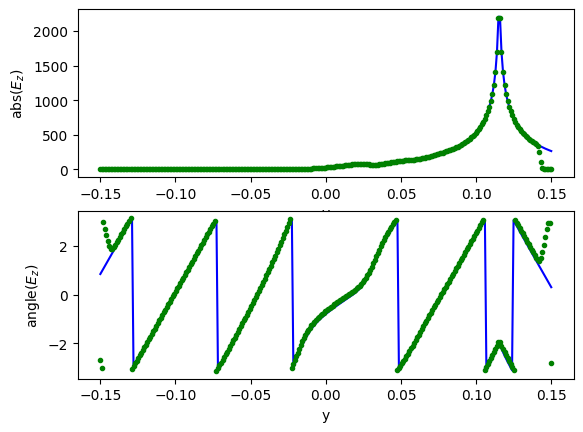

start time:  19:57:46
end time:    20:25:00


In [24]:
x = np.linspace(-len(eps_data)*deltaX/2., len(eps_data)*deltaX/2., len(eps_data))

fig2 = plt.figure(2)
f2 = fig2.add_subplot(211)
f2.plot(x,abs(Eztheory1[:,int(len(Eztheory1)/2)]),'b')
f2.plot(x,abs(Ezfdtd[:,int(len(Ezfdtd)/2)]),'.g')
f2.set_xlabel(r'y')
f2.set_ylabel(r'abs($E_{z}$)')
f2 = fig2.add_subplot(212)
f2.plot(x,np.angle(Eztheory1)[:,int(len(Eztheory1)/2)],'b')
f2.plot(x,-np.angle(Ezfdtd)[:,int(len(Ezfdtd)/2)],'.g')
f2.set_xlabel(r'y')
f2.set_ylabel(r'angle($E_{z}$)')

plt.show()

print('start time: ', start_time)
print('end time:   ', tm.strftime('%H:%M:%S'))